In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warehouse
import seaborn as sb


import inspect

def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]



Read Data
---

In [21]:
import os
import sys


ga_df = None
greedy_df = None
cws_df = None
tabu_df = None

with open("../results/ga.results", "r") as ga_file,\
     open("../results/greedy.results", "r") as greedy_file,\
     open("../results/cws.results", "r") as cws_file,\
     open("../results/tabu.results", "r") as tabu_file:
    ga_df = warehouse.read(ga_file.read(), type="standard")
    greedy_df = warehouse.read(greedy_file.read(), type="standard")
    cws_df = warehouse.read(cws_file.read(), type="standard")
    tabu_df = warehouse.read(tabu_file.read(), type="standard")
    
ga_work_df = None
greedy_work_df = None
cws_work_df = None
tabu_work_df = None

with open("../results/ga_robots.results", "r") as ga_file,\
     open("../results/greedy_robots.results", "r") as greedy_file,\
     open("../results/cws_robots.results", "r") as cws_file,\
     open("../results/tabu_robots.results", "r") as tabu_file:
    ga_work_df = warehouse.read(ga_file.read(), type="work")
    greedy_work_df = warehouse.read(greedy_file.read(), type="work")
    cws_work_df = warehouse.read(cws_file.read(), type="work")
    tabu_work_df = warehouse.read(tabu_file.read(), type="work")


print(os.path.abspath(os.pardir))

/Users/jonval/WARNING/School/KeX/warehouse_cpp


Group data
---

In [22]:
ga_G = ga_df.groupby("group")
ga_groups = list(ga_G.groups.keys())

greedy_G = greedy_df.groupby("group")
greedy_groups = list(greedy_G.groups.keys())

cws_G = cws_df.groupby("group")
cws_groups = list(cws_G.groups.keys())

tabu_G = tabu_df.groupby("group")
tabu_groups = list(tabu_G.groups.keys())


ga_groups.sort()
greedy_groups.sort()
cws_groups.sort()
tabu_groups.sort()

## Work groups


ga_work_G = ga_work_df.groupby("group")
ga_work_groups = list(ga_work_G.groups.keys())

greedy_work_G = greedy_work_df.groupby("group")
greedy_work_groups = list(greedy_work_G.groups.keys())

cws_work_G = cws_work_df.groupby("group")
cws_work_groups = list(cws_work_G.groups.keys())

tabu_work_G = tabu_work_df.groupby("group")
tabu_work_groups = list(tabu_work_G.groups.keys())

ga_work_groups.sort()
greedy_work_groups.sort()
cws_work_groups.sort()
tabu_work_groups.sort()

available_groups = greedy_groups
available_work_groups = greedy_work_groups

Score Distribution
---

['0', '1', '2', '3', '4', '5', '6']


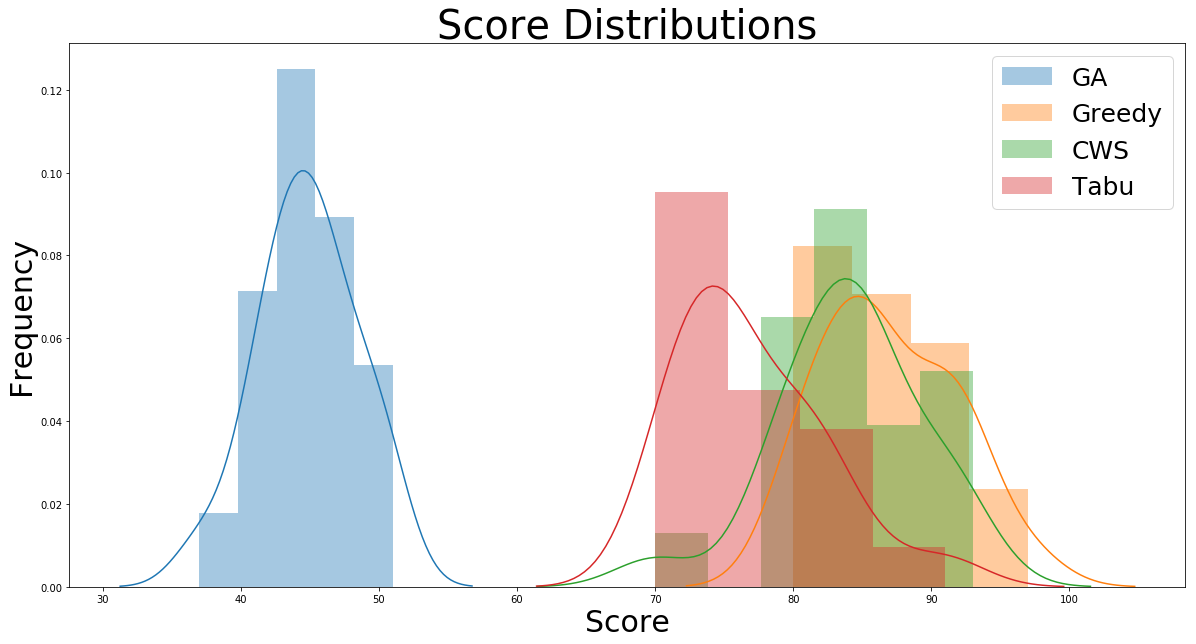

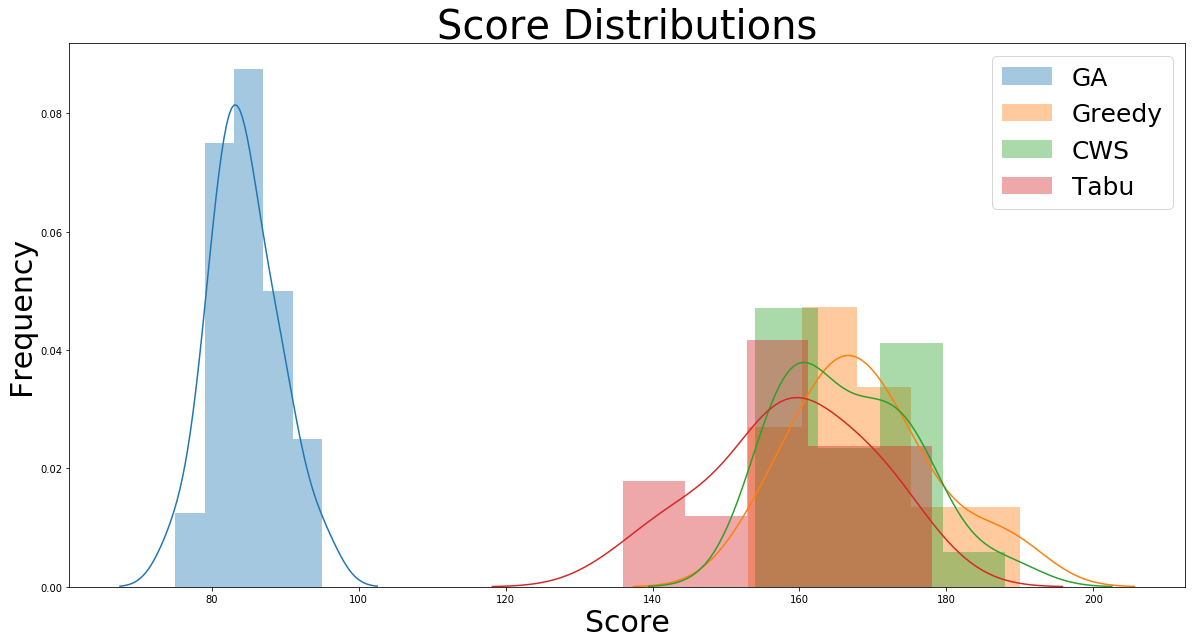

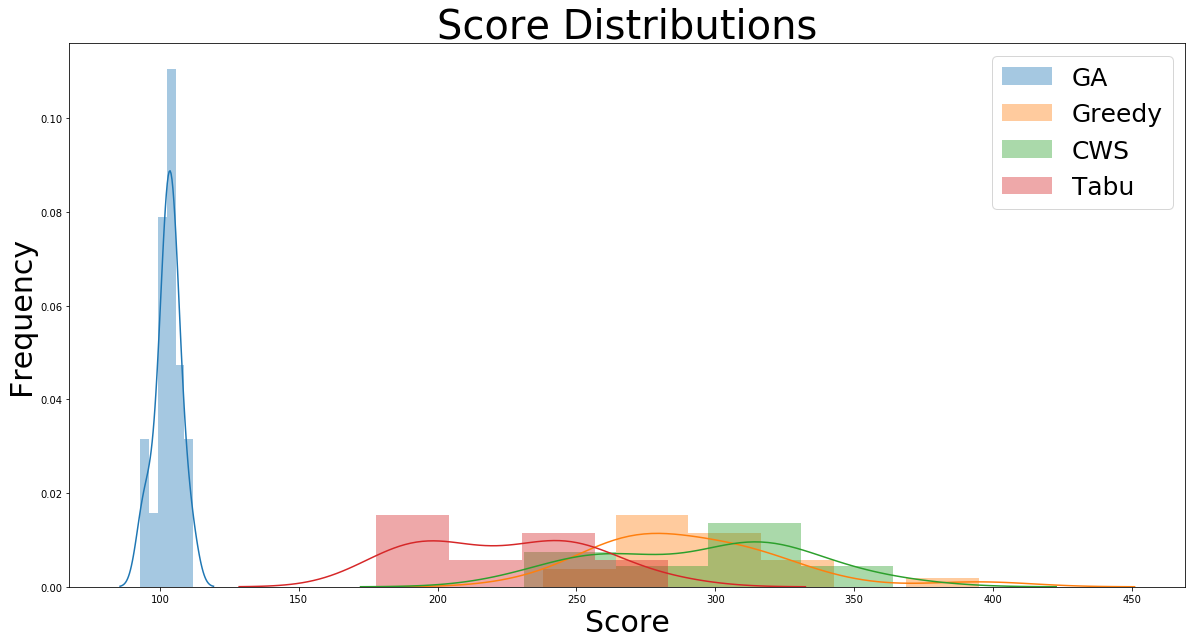

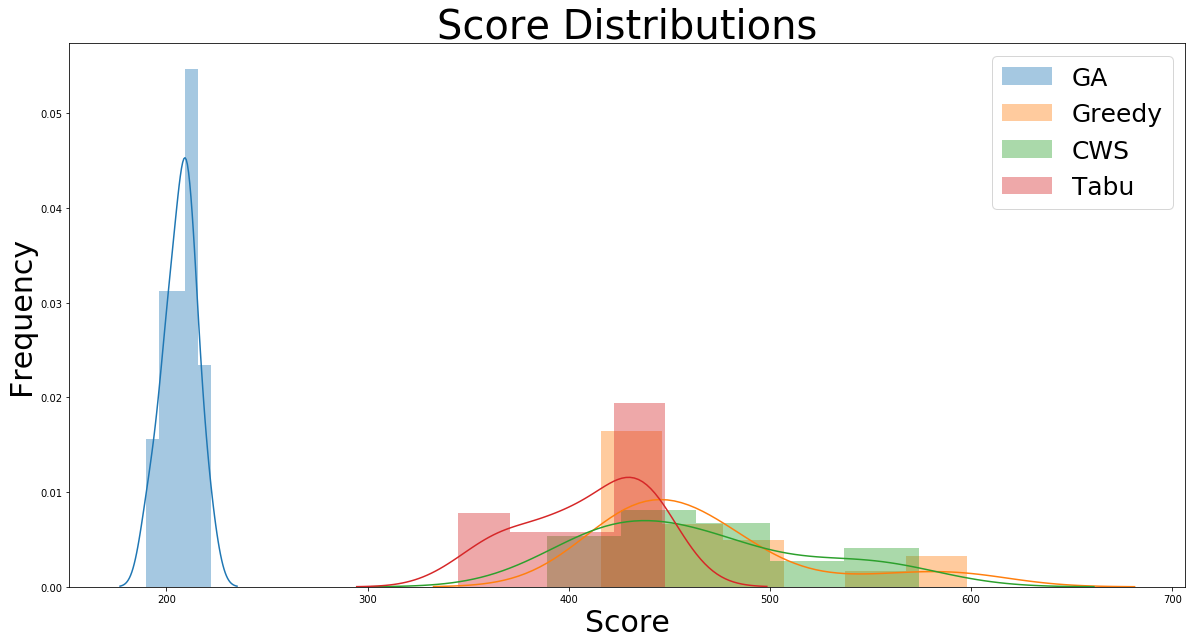

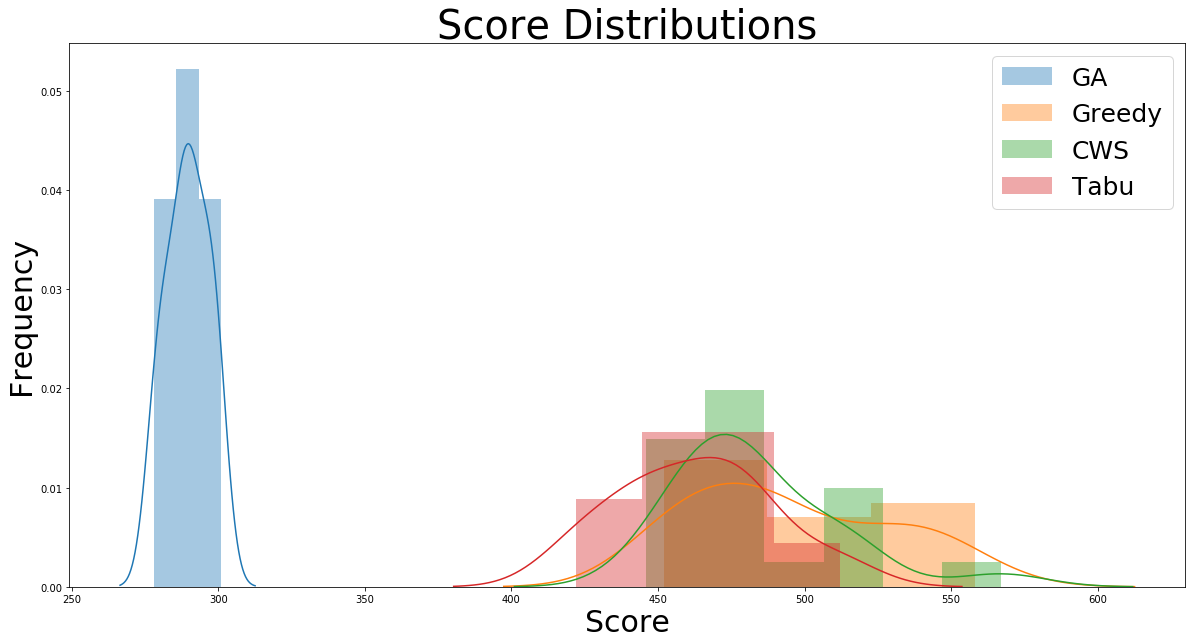

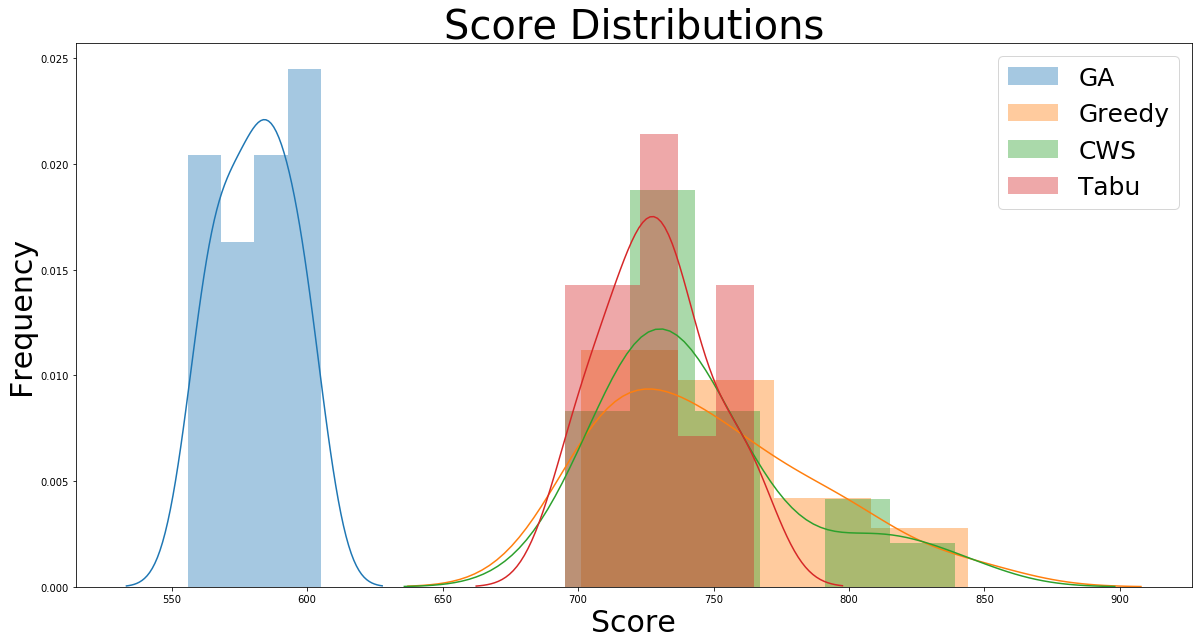

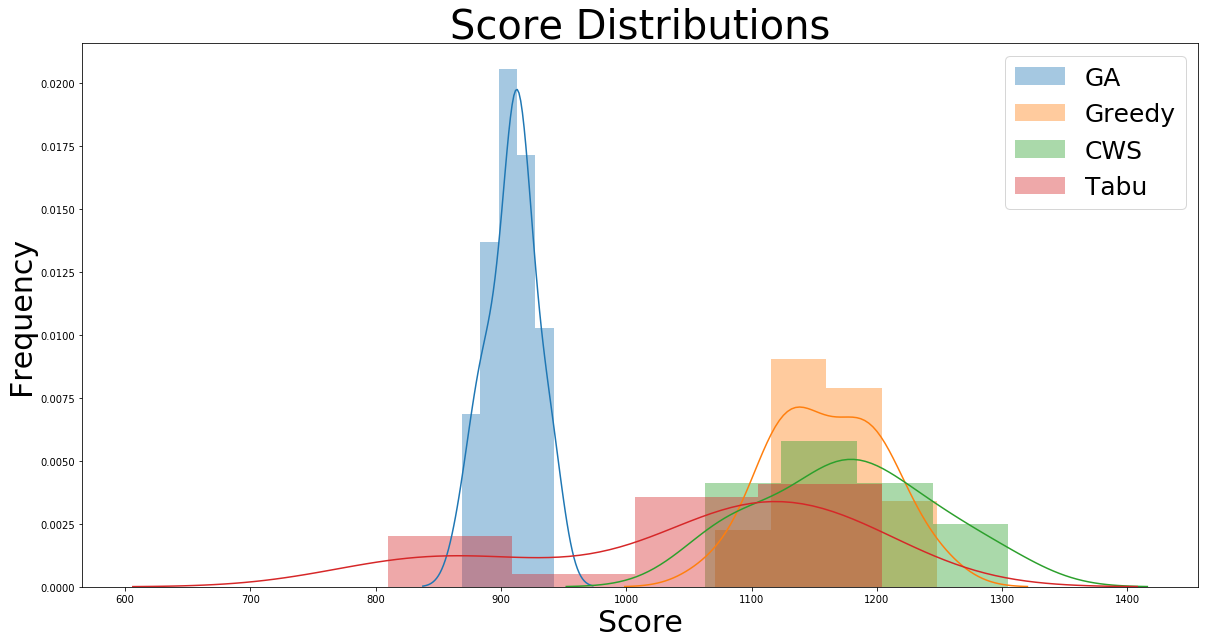

In [23]:
print(available_groups)
names = ["dist_XS", "dist_S", "dist_M", "dist_L", "dist_XL", "dist_XXL", "dist_XXXL"]
for name, i in zip(names, range(len(available_groups))):
    fig, ax = plt.subplots(1, figsize=(20, 10))

    group = i

    try:
        ga_data = ga_G.get_group(ga_groups[group])
        sb.distplot(ga_data["scores"], label="GA", ax=ax)
        ax.legend(fontsize=25)
    except Exception as e:
        print("Failed to plot GA %s" % str(e))

    try:
        greedy_data = greedy_G.get_group(greedy_groups[group])
        sb.distplot(greedy_data["scores"], label="Greedy", ax=ax)
        ax.legend(fontsize=25)
    except Exception as e:
        print("Failed to plot greedy %s" % str(e))

    try:
        cws_data = cws_G.get_group(cws_groups[group])
        sb.distplot(cws_data["scores"], label="CWS", ax=ax)
        ax.legend(fontsize=25)
    except Exception as e:
        print("Failed to plot cws %s" % (str(e)))

    try:
        tabu_data = tabu_G.get_group(tabu_groups[group])
        sb.distplot(tabu_data["scores"], label="Tabu", ax=ax)
        ax.legend(fontsize=25)
    except Exception as e:
        print("Failed to plot tabu %s" % str(e))

    ax.set_title("Score Distributions", fontsize=40)
    ax.set_ylabel("Frequency", fontsize=30)
    ax.set_xlabel("Score", fontsize=30) 

    fig.savefig("outputs/%s.pdf" % name, bbox_inches='tight')

    plt.show()

Score Box plots
---

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


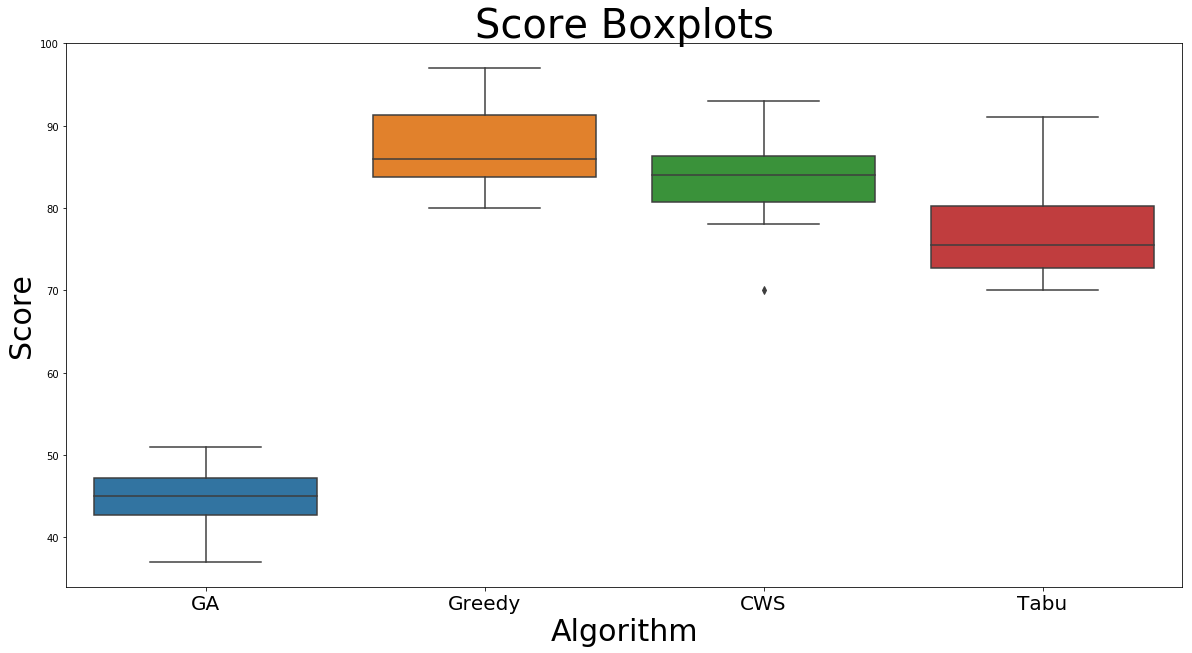

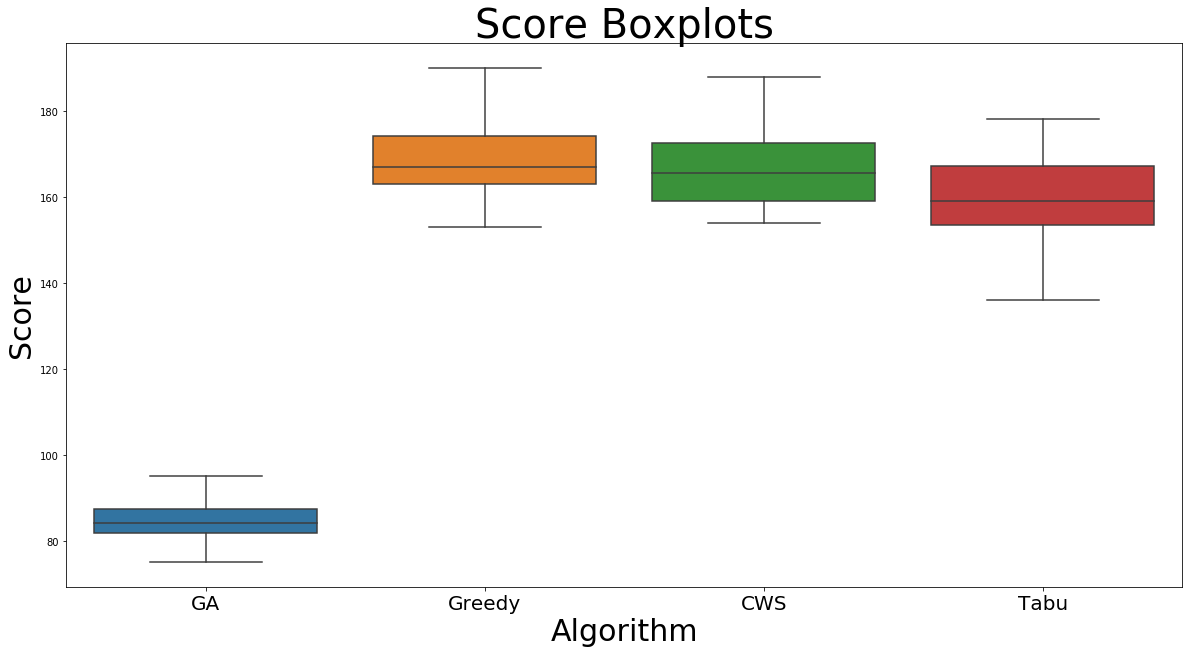

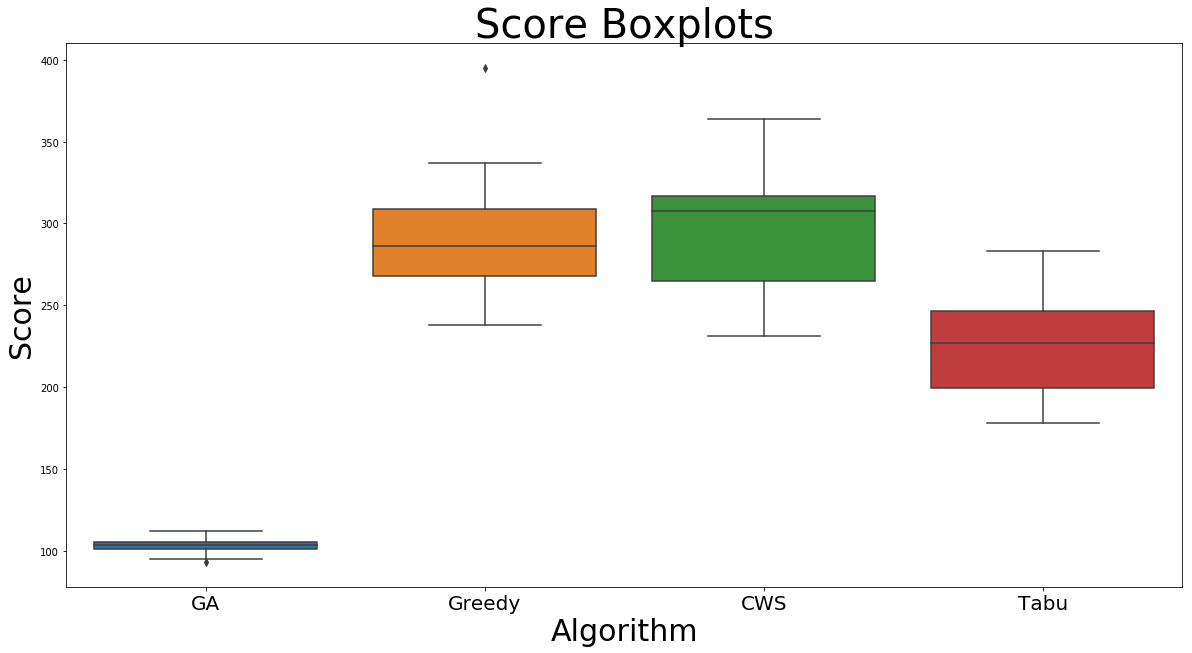

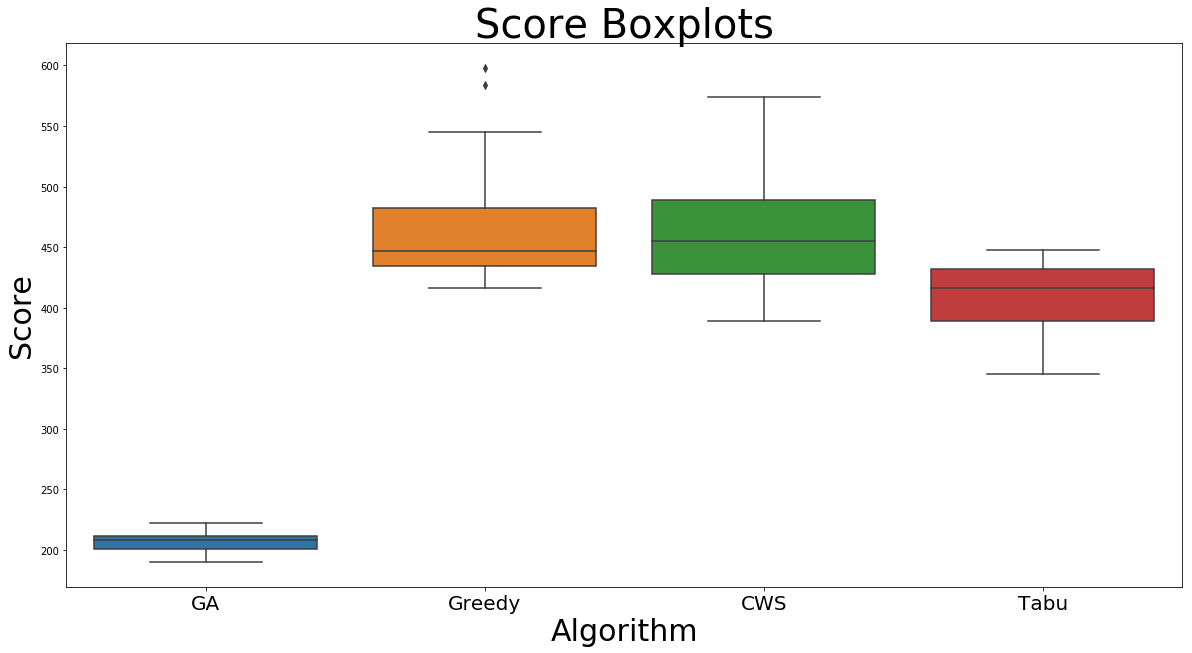

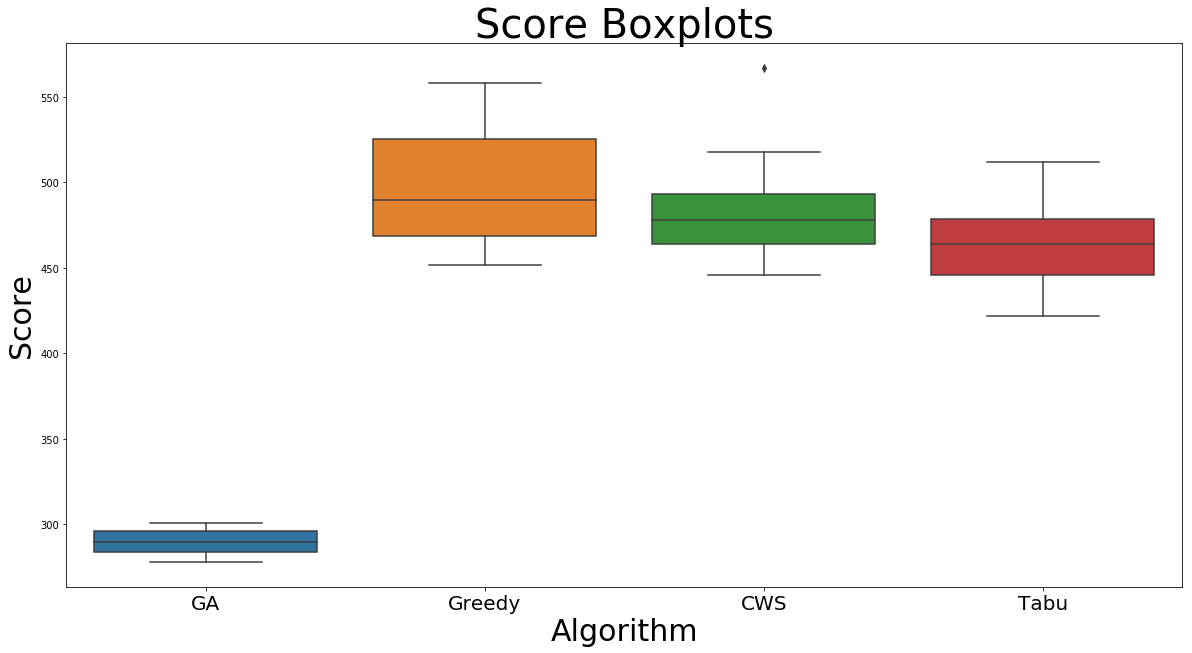

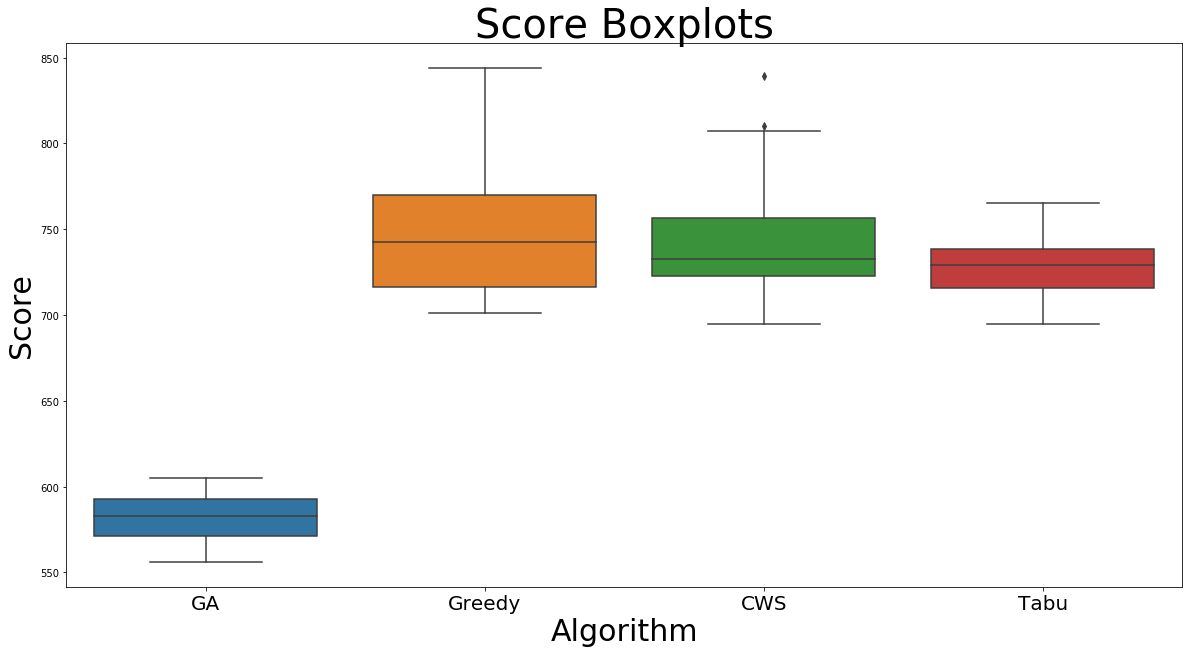

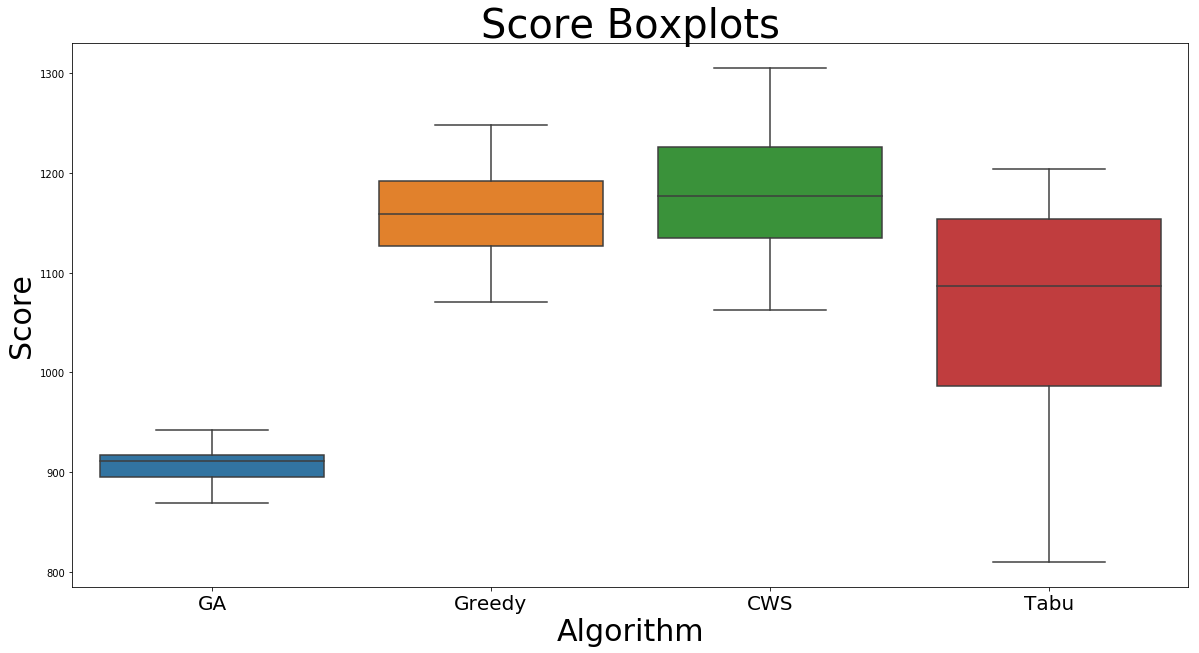

In [31]:
names = ["box_XS", "box_S", "box_M", "box_L", "box_XL", "box_XXL", "box_XXXL"]
for name, i in zip(names, range(len(available_groups))):
    fig, ax = plt.subplots(1, figsize=(20, 10))

    group = i
    
    names = []
    scores = []

    try:
        ga_data = ga_G.get_group(ga_groups[group])
        names.append("GA")
        scores.append(ga_data["scores"])
    except Exception as e:
        print("Failed to get GA %s" % str(e))

    try:
        greedy_data = greedy_G.get_group(greedy_groups[group])
        names.append("Greedy")
        scores.append(greedy_data["scores"])
    except Exception as e:
        print("Failed to get greedy %s" % str(e))

    try:
        cws_data = cws_G.get_group(cws_groups[group])
        names.append("CWS")
        scores.append(cws_data["scores"])
    except Exception as e:
        print("Failed to get cws %s" % (str(e)))

    try:
        tabu_data = tabu_G.get_group(tabu_groups[group])
        names.append("Tabu")
        scores.append(tabu_data["scores"])
    except Exception as e:
        print("Failed to get tabu %s" % str(e))

    ax.set_title("Score Boxplots", fontsize=40)
    ax.set_ylabel("Score", fontsize=30)
    ax.set_xlabel("Algorithm", fontsize=30)

    sb.boxplot(x=names, y=scores)
    ax.set_xticklabels(names, fontsize=20)


    fig.savefig("outputs/%s.pdf" % name, bbox_inches='tight')

    plt.show()

Score Distribution Development
---

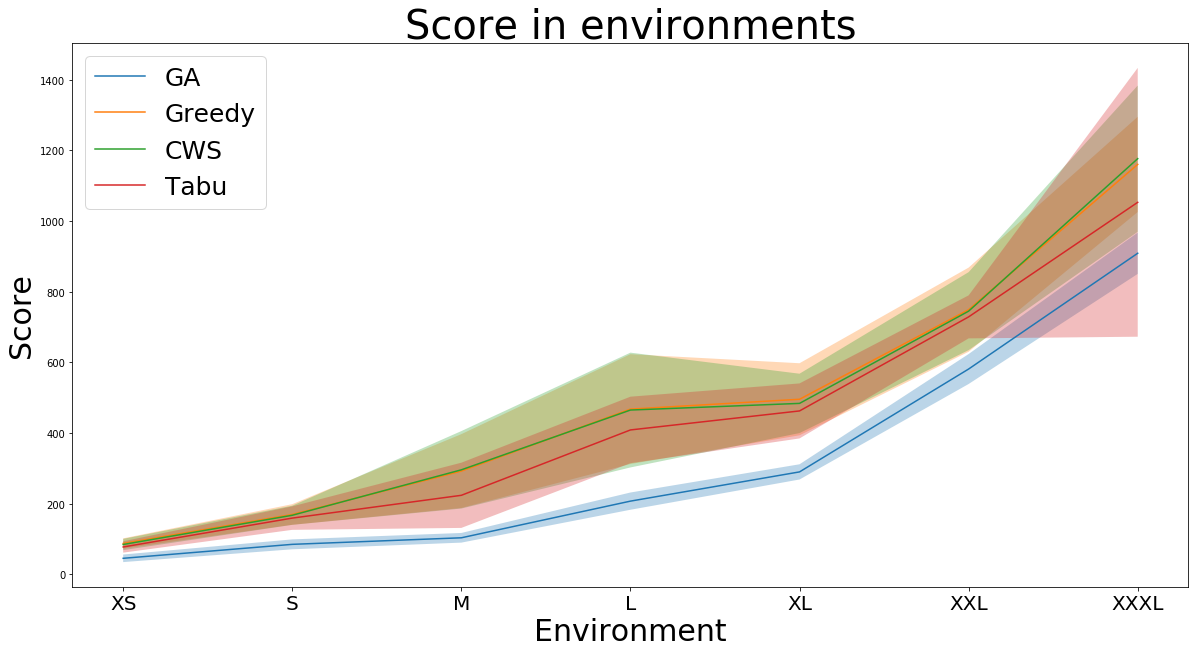

In [33]:
fig, ax = plt.subplots(1, figsize=(20, 10))

Gs = [
    ("GA", ga_G),
    ("Greedy", greedy_G),
    ("CWS", cws_G),
    ("Tabu", tabu_G)
]

env_names = ["XS", "S", "M", "L", "XL", "XXL", "XXXL"]
for name, G in Gs:
    packages = []
    means = []
    stds = []
    for group in available_groups:
        try:
            g = G.get_group(group)
            packages.append(group)
            means.append(g["scores"].mean())
            stds.append(g["scores"].std())
        except Exception as e:
            print("Failed to plot group %s for %s: %s" % (str(group), name, str(e)))
    
    means = np.array(means)
    stds = np.array(stds)
    #print(len(packages))
    #print(len(means))
    sb.lineplot(packages[:len(means)], means, ax=ax, label=name)
    ax.legend(fontsize=25)
    ax.fill_between(packages[:len(means)], means + stds * 3, means - stds * 3, alpha=0.3)
    ax.set_xticklabels(env_names, fontsize=20)



ax.set_title("Score in environments", fontsize=40)
ax.set_ylabel("Score", fontsize=30)
ax.set_xlabel("Environment", fontsize=30)     
fig.savefig("outputs/dist_summary.pdf", bbox_inches='tight')

plt.show()       


Workload Distributions
---

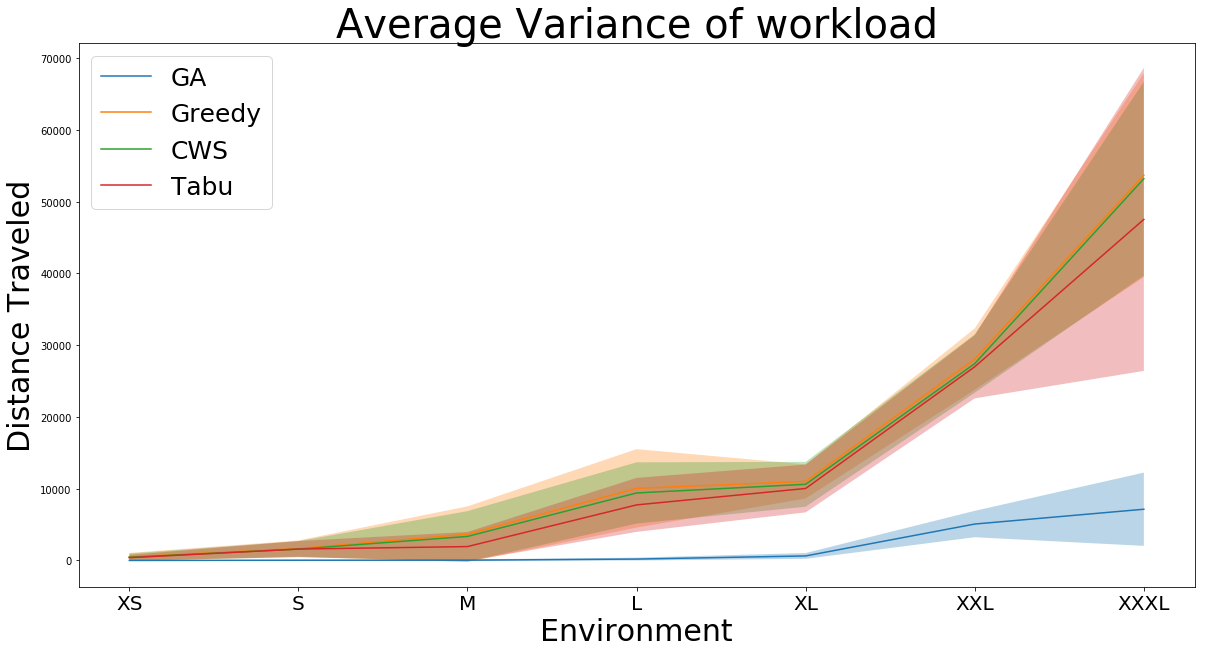

In [34]:
import ast

fig, ax = plt.subplots(1, figsize=(20, 10))

Gs = [
    ("GA", ga_work_G),
    ("Greedy", greedy_work_G),
    ("CWS", cws_work_G),
    ("Tabu", tabu_work_G)
]

env_names = ["XS", "S", "M", "L", "XL", "XXL", "XXXL"]

for name, G in Gs:
    packages = []
    means = []
    stds = []
    for group in available_groups:
        try:
            g = G.get_group(group)
            packages.append(group)
            mmeans = []
            for item in g["data"]:
                arr = np.array(ast.literal_eval(item))
                mmeans.append(arr.var())
            mmeans = np.array(mmeans)
            means.append(mmeans.mean())
            stds.append(mmeans.std())
        except Exception as e:
            print("Failed to plot group %s for %s - %s" % (group, name, str(e)))
    
    means = np.array(means)
    stds = np.array(stds)
    sb.lineplot(packages, means, ax=ax, label=name)
    ax.legend(fontsize=25)
    ax.fill_between(packages, means + stds * 3, means - stds * 3, alpha=0.3)
    ax.set_xticklabels(env_names, fontsize=20)



ax.set_title("Average Variance of workload", fontsize=40)
ax.set_ylabel("Distance Traveled", fontsize=30)
ax.set_xlabel("Environment", fontsize=30)
fig.savefig("outputs/robot_workload_summary.pdf", bbox_inches='tight')

plt.show()       

Complexity Distributions
---

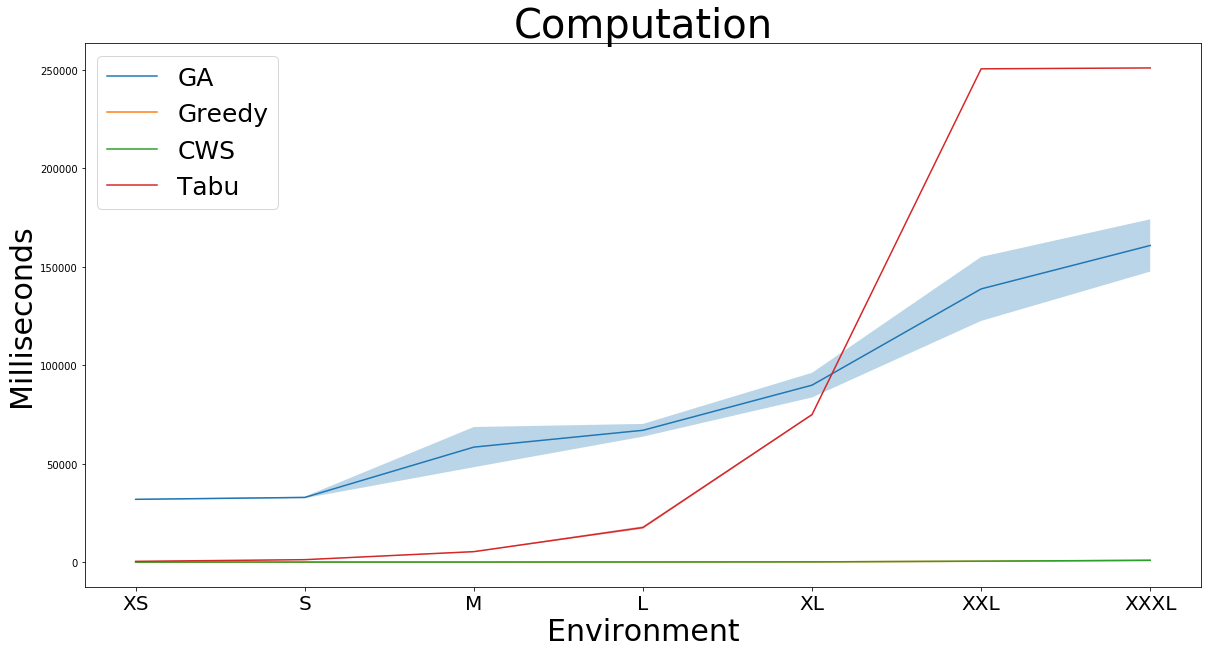

In [35]:
fig, ax = plt.subplots(1, figsize=(20, 10))

Gs = [
    ("GA", ga_G),
    ("Greedy", greedy_G),
    ("CWS", cws_G),
    ("Tabu", tabu_G)
]

env_names = ["XS", "S", "M", "L", "XL", "XXL", "XXXL"]

for name, G in Gs:
    packages = []
    means = []
    stds = []
    for group in available_groups:
        try:
            g = G.get_group(group)
            packages.append(group)
            
            means.append(g["computation"].mean())
            stds.append(g["computation"].std())
        except Exception as e:
            print("Failed to plot group %s for %s: %s" % (group, name, str(e)))
    
    means = np.array(means)
    stds = np.array(stds)
    sb.lineplot(packages, means, ax=ax, label=name)
    ax.legend(fontsize=25)
    ax.fill_between(packages, means + stds * 3, means - stds * 3, alpha=0.3)
    ax.set_xticklabels(env_names, fontsize=20)



ax.set_title("Computation", fontsize=40)
ax.set_xlabel("Environment", fontsize=30)
ax.set_ylabel("Milliseconds", fontsize=30)
        
fig.savefig("outputs/algorithm_workload_summary.pdf", bbox_inches='tight')

plt.show()       
